In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

- Predicting training completions for next quarter using SARIMA Model

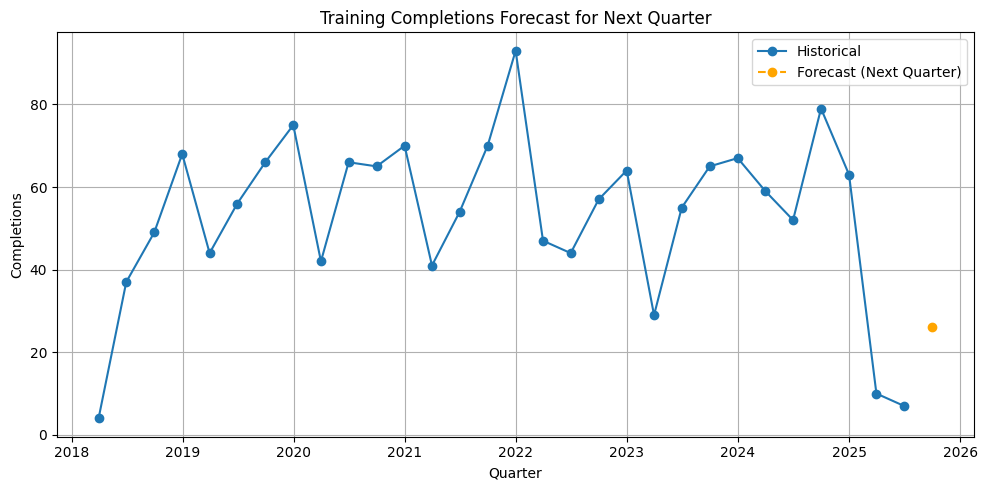

Forecast for Next Quarter:
2025-09-30    26.07
Freq: Q-DEC, dtype: float64


In [2]:
# Load the dataset
df_fact = pd.read_csv("fact_training.csv")

# Convert CompletionDate to datetime
df_fact['CompletionDate'] = pd.to_datetime(df_fact['CompletionDate'], errors='coerce')

# Filter completed trainings
completed_df = df_fact[df_fact['CompletionDate'].notna()]

# Group by quarter
quarterly_completions = completed_df.groupby(pd.Grouper(key='CompletionDate', freq='Q')).size()
quarterly_completions = quarterly_completions.asfreq('Q').fillna(0)

# Fit SARIMA model
model = SARIMAX(quarterly_completions, 
                order=(1, 1, 1), 
                seasonal_order=(1, 1, 1, 4),
                enforce_stationarity=False,
                enforce_invertibility=False)
fit = model.fit(disp=False)

# Forecast the next quarter
n_periods = 1
forecast = fit.forecast(steps=n_periods)
forecast_index = pd.date_range(start=quarterly_completions.index[-1] + pd.offsets.QuarterEnd(),
                               periods=n_periods, freq='Q')
forecast_series = pd.Series(forecast.values, index=forecast_index)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(quarterly_completions, label="Historical", marker='o')
plt.plot(forecast_series, label="Forecast (Next Quarter)", linestyle='--', marker='o', color='orange')
plt.title("Training Completions Forecast for Next Quarter")
plt.xlabel("Quarter")
plt.ylabel("Completions")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print forecast
print("Forecast for Next Quarter:")
print(forecast_series.round(2))


- Predicting training completions for next 3 quarter using SARIMA Model

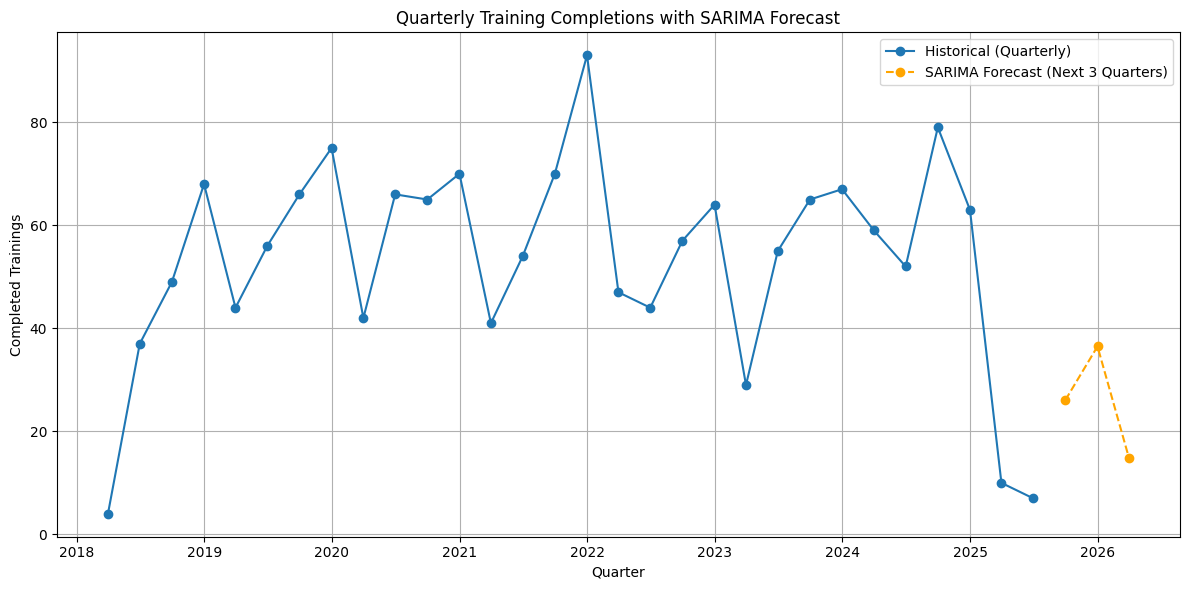

SARIMA Forecast for Next 3 Quarters:
2025-09-30    26.07
2025-12-31    36.49
2026-03-31    14.85
Freq: Q-DEC, dtype: float64


In [3]:
# Load the fact table (adjust path if needed)
df_fact = pd.read_csv("fact_training.csv")

# Convert CompletionDate to datetime
df_fact['CompletionDate'] = pd.to_datetime(df_fact['CompletionDate'], errors='coerce')

# Filter only completed trainings
completed_df = df_fact[df_fact['CompletionDate'].notna()]

# Group by quarter and count completions
quarterly_completions = completed_df.groupby(pd.Grouper(key='CompletionDate', freq='Q')).size()
quarterly_completions = quarterly_completions.asfreq('Q').fillna(0)

# Fit SARIMA model
model = SARIMAX(quarterly_completions, 
                order=(1, 1, 1), 
                seasonal_order=(1, 1, 1, 4),
                enforce_stationarity=False,
                enforce_invertibility=False)
fit = model.fit(disp=False)

# Forecast next 3 quarters
n_periods = 3
forecast = fit.forecast(steps=n_periods)
forecast_index = pd.date_range(start=quarterly_completions.index[-1] + pd.offsets.QuarterEnd(),
                               periods=n_periods, freq='Q')
forecast_series = pd.Series(forecast.values, index=forecast_index)

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(quarterly_completions, label="Historical (Quarterly)", marker='o')
plt.plot(forecast_series, label="SARIMA Forecast (Next 3 Quarters)", linestyle='--', marker='o', color='orange')
plt.title("Quarterly Training Completions with SARIMA Forecast")
plt.ylabel("Completed Trainings")
plt.xlabel("Quarter")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print forecast values
print("SARIMA Forecast for Next 3 Quarters:")
print(forecast_series.round(2))


- Regression Analysis: Model impact of training time and frequency on performance scores

In [4]:
from sklearn.linear_model import LinearRegression

# 1. Load data
df_fact = pd.read_csv("fact_training.csv")

# 2. Convert date columns to datetime
df_fact['EnrollmentDate'] = pd.to_datetime(df_fact['EnrollmentDate'], errors='coerce')
df_fact['CompletionDate'] = pd.to_datetime(df_fact['CompletionDate'], errors='coerce')

# 3. Filter only completed trainings
completed_df = df_fact[df_fact['CompletionDate'].notna()]

# 4. Calculate training frequency per employee
course_counts = completed_df.groupby('EmployeeID')['CourseID'].nunique().reset_index()
course_counts.columns = ['EmployeeID', 'CourseFrequency']

# 5. Merge course frequency into the main dataset
df_fact = pd.merge(df_fact, course_counts, on='EmployeeID', how='left')

# 6. Compute average performance score
df_fact['PerformanceScore'] = df_fact[['SkillScore_Communication',
                                       'SkillScore_TechEfficiency',
                                       'SkillScore_Teamwork']].mean(axis=1)

# 7. Prepare data for regression
df_model = df_fact[['DurationMinutes', 'CourseFrequency', 'PerformanceScore']].dropna()
X = df_model[['DurationMinutes', 'CourseFrequency']]
y = df_model['PerformanceScore']

# 8. Fit linear regression model
reg = LinearRegression()
reg.fit(X, y)

# 9. Print interpretable results
print("\n=== Regression Analysis: Impact of Training on Performance ===")
print(f"Intercept: {reg.intercept_:.2f}")
print(f"Duration Coefficient: {reg.coef_[0]:.4f}")
print(f"Frequency Coefficient: {reg.coef_[1]:.4f}\n")

# Interpret DurationMinutes effect
if reg.coef_[0] > 0:
    print(f"Every additional minute of training increases the performance score by approximately {reg.coef_[0]:.4f} points. Longer training positively influences skill development.")
elif reg.coef_[0] < 0:
    print(f"Every additional minute of training decreases the performance score by {abs(reg.coef_[0]):.4f} points — suggesting potential **fatigue** or **inefficient time usage**.")
else:
    print("⏸ Training duration shows **no significant effect** on performance.")

# Interpret CourseFrequency effect
if reg.coef_[1] > 0:
    print(f"Completing one additional course increases the performance score by approximately {reg.coef_[1]:.4f} points — highlighting that **more frequent training leads to better outcomes**.")
elif reg.coef_[1] < 0:
    print(f"One more course reduces the score by {abs(reg.coef_[1]):.4f} points,possibly due to overtraining or low-quality repetition.")
else:
    print("⏸ Training frequency shows **no measurable impact** on performance.")




=== Regression Analysis: Impact of Training on Performance ===
Intercept: 2.98
Duration Coefficient: 0.0006
Frequency Coefficient: -0.0209

Every additional minute of training increases the performance score by approximately 0.0006 points. Longer training positively influences skill development.
One more course reduces the score by 0.0209 points,possibly due to overtraining or low-quality repetition.


- ANOVA: Compare mean skill scores across multiple departments to identify statistically significant performance disparities

In [5]:
from scipy.stats import f_oneway

# Step 1: Load data
df_fact = pd.read_csv("fact_training.csv")
df_employee = pd.read_csv("dim_employee.csv")
df_team = pd.read_csv("dim_team.csv")

# Step 2: Merge to get Team ID and Team Name
df = pd.merge(df_fact, df_employee[['EmployeeID', 'Team ID']], on='EmployeeID', how='left')
df = pd.merge(df, df_team[['Team ID', 'Team']], on='Team ID', how='left')

# Step 3: Compute average performance score
df['PerformanceScore'] = df[['SkillScore_Communication',
                             'SkillScore_TechEfficiency',
                             'SkillScore_Teamwork']].mean(axis=1)

# Step 4: Drop missing values
df = df[['Team', 'PerformanceScore']].dropna()

# Step 5: Group performance scores by department
grouped_scores = df.groupby('Team')['PerformanceScore'].apply(list)

# Step 6: Perform ANOVA
anova_result = f_oneway(*grouped_scores)

# Step 7: Output with interpretation
print("\n=== ANOVA: Skill Score Comparison Across Teams ===")
print(f"F-statistic: {anova_result.statistic:.4f}")
print(f"P-value: {anova_result.pvalue:.4f}")

if anova_result.pvalue < 0.05:
    print("Conclusion: There is a **statistically significant** difference in mean performance scores between teams.")
else:
    print("Conclusion: No statistically significant difference found in performance scores across teams.")



=== ANOVA: Skill Score Comparison Across Teams ===
F-statistic: 0.5622
P-value: 0.7290
Conclusion: No statistically significant difference found in performance scores across teams.
